## DDQN and Breakout Atari Game

The [Breakout](https://gymnasium.farama.org/environments/atari/breakout/) is is part of the [Atari environments](https://gymnasium.farama.org/environments/atari/), a set of Atari 2600 games. The agent moves a paddle and hit a ball in a brick wall at the top of the screen. The goal is to destroy the brick wall.

- The Action Space is discrete and deterministic with 4 actions: 0 (noop), 1 (fire), 2 (right) and 3 (left).
- The Observation Space can be in two form: the screen image (210x160x3) or the "RAM" (128 bytes), which is a vector of 128 bytes containing the values of the registers and inputs of the Atari 2600. The RAM is a low-dimensional representation of the game state and can be used with our implementation of the DDQN algorithm. The screen image is a high-dimensional representation of the game state and to use it we need to modify our neural network architecture adding a convolutional layer in order to extract the features from the image.

Gymnasium includes [ALE-py](https://pypi.org/project/ale-py/), the **Arcade Learning Environment (ALE)** which is a simple framework that allows researchers to develop AI agents for Atari 2600 games. It is built on top of the Atari 2600 emulator Stella and separates the details of emulation from agent design. However, it doesn’t include the atari ROMs which are necessary to make any of the atari environments. To install the atari ROM, use pip install "gymnasium[atari, accept-rom-license]".

1 - import the environment from Gymnasium and show it with a random policy

In [19]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'ALE/Assault-v5’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym
breakout = gym.make('ALE/Breakout-ram-v5', render_mode="rgb_array")
#breakout = gym.make('Acrobot-v1', render_mode="rgb_array")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


2 - Show the policy in action by rendering the environment several times after different decisions from a random policy:

In [98]:
# YOUR CODE HERE

# You can use a similar function already used for other environments, however you need to consider that 
# the ball does not appear until 'FIRE' action is executed. So you need to add a check for that. At the beginning, you need to fire
# as the first action, and then you have to fire after loosing each live.

import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=200):
    for _ in range(n_episodes):
        state = env.reset()[0]
        
        terminated, truncated = False, False
        
        lives = 5;
        fire = True;

        steps = 0;
        while not (terminated or truncated) and steps < max_steps:
            if(pi is None):
                action = np.random.choice((0, 1, 2, 3))
            else:
                action = pi.select_action(agent.online_model, state)

            # the ball does not appear until 'FIRE' action is executed
            if(fire):
                action = 1
                fire = False;
            
            state, reward, terminated, truncated, info = env.step(action)
            
            if(info['lives'] != lives):
                lives = info['lives']
                fire = True;

            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1


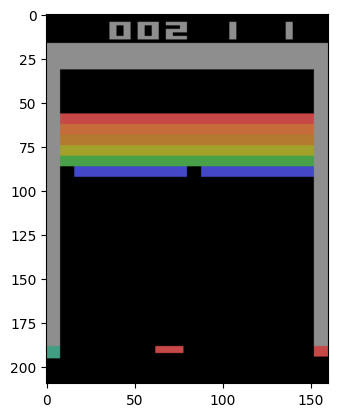

In [99]:
show_policy(breakout, None)

3 - Create a neural network as a function approximator for the Q-function.

In [7]:
# YOUR CODE HERE

# Add the code for a neural network using the PyTorch library

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

         # creating the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        # connecting the output layer 
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        
        # finally, for the output layer
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals



4 - Create a the code of two strategy for exploration and exploitation

In [107]:
# YOUR CODE HERE

# Add the code for an exploration strategy based on the epsilon-greedy algorithm

class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=3000000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        #with torch.no_grad():
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [12]:
# YOUR CODE HERE

# Add the code for a exploitation strategy based on the greedy algorithm in order to evaluate your policy

class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

5 - Write a Replay Memory class to store the transitions

In [9]:
# YOUR CODE HERE

# You can use the same function already used for other environments

class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones       = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, done = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.dones[idxs])
                      
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

6 - Write the code of the NFQ algorithm

In [30]:
# YOUR CODE HERE

# Add the code for the NFQ algorithm, with all the needed methods inserted in the class

import random 
import torch
import torch.optim as optim
from itertools import count

class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory, max_gradient_norm,
                 seed, n_warmup_batches, target_update_steps):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # store the objects
        self.env = env
        self.replay_memory = replay_memory
        self.max_gradient_norm = max_gradient_norm
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

    def train(self, gamma, max_minutes, max_episodes, goal_reward):
            
        # timing variables
        training_start = time.time()

        self.gamma = gamma
        
        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        # we synchronize the online and target models at the beginning of training
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan

        training_time = 0
        
        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()
            
            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # reset the environment before starting the episode
            state, is_terminal = self.env.reset()[0], False

            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience in the replay memory
                state, is_terminal = self.interaction_step(state)
                
                # if the replay memory has enough samples, we can create 
                # the mini-batch and optimize the model 
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:

                    # load the experiences as tensors for training
                    # from the replay memory
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)

                    # optimize the model
                    self.optimize_model(experiences)
                
                # synchronize the target model with the online model
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            # average stats over some recent episodes
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            # report results
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            
            # conclude training if we have met any of the stopping conditions
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print(u'--> reached_max_minutes ')
                if reached_max_episodes: print(u'--> reached_max_episodes ')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward ')
                break
                
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=1)
        
        return result, final_eval_score, final_eval_std, training_time


    def optimize_model(self, experiences):

        # convert the experiences into separate arrays for each element
        states, actions, rewards, next_states, is_terminals = experiences

        # get the batch size
        batch_size = len(is_terminals)
            
        # get the values of the Q-function at next state (remember to detach
        # notice: we now query the "target" network to get the estimate of the next state 
        q_sp = self.target_model(next_states).detach()
            
        # get the max value of the next state
        max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
        
        # one important step, often overlooked, is to ensure 
        # terminal states are grounded to zero
        max_a_q_sp *= (1 - is_terminals)
            
        # calculate the target 
        target_q_sa = rewards + self.gamma * max_a_q_sp

        # finally, we get the current estimate of Q(s,a)    
        # notice: here we query the current "online" network
        q_sa = self.online_model(states).gather(1, actions)

        # create the errors
        td_errors = q_sa - target_q_sa
        
        # calculate the loss, and optimize the online network
        value_loss = td_errors.pow(2).mul(0.5).mean()

        self.optimizer.zero_grad()
        value_loss.backward()

        # clip the gradients to the max_gradient_norm.
        torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)
        
        self.optimizer.step()

    def interaction_step(self, state):
        
        # interact with environment using the exploration policy
        # notice how we use the online model for selecting actions
        action = self.train_strategy.select_action(self.online_model, state)

        # collect an experience tuple as usual    
        new_state, reward, is_terminal, is_truncated, info = self.env.step(action)

        # a failure is defined as follows
        is_failure = is_terminal and not is_truncated
        
        # collect the experience and store it in the replay buffer
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_memory.store(experience)

        # update episode stats
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        
        return new_state, is_terminal

    def update_network(self):
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)
        
    def evaluate(self, n_episodes=1):

        # create a list of returns of each episode
        rs = []

        # loop over the episodes
        for _ in range(n_episodes):

            # reset the environment before starting the episode
            s, d = self.env.reset()[0], False

            # initialize the return
            rs.append(0)

            # interact with the environment until the episode is done 
            while(True):

                # interact with environment using the exploitation policy
                a = self.eval_strategy.select_action(self.online_model, s)

                # collect an experience tuple as usual
                s, r, d, t, _ = self.env.step(a)

                # add the reward to the return of the episode
                rs[-1] += r

                if d or t:
                    break
                
        return np.mean(rs), np.std(rs)

7 - Apply NFQ to the pendulum environment. 

In [113]:
# YOUR CODE HERE

# Apply NFQ to the breakout environment, use a goal_reward of 10 and a gamma of 0.99   

gamma = 1

max_minutes = 5*60
max_episodes = 10000
goal_reward = 10

ddqn_results = []
best_ddqn_agent = None
best_ddqn_eval_score = float('-inf')

target_update_steps = 3
n_warmup_batches = 5

max_gradient_norm = float('inf')

seed = 42

nS, nA = breakout.observation_space.shape[0], breakout.action_space.n

print('Training started...')
    
online_model = FCQ(nS, nA, hidden_dims=(512,128))
target_model = FCQ(nS, nA, hidden_dims=(512,128))
optimizer = optim.RMSprop(online_model.parameters(), lr=0.0007)
replay_memory = ReplayMemory(max_size=1000000, batch_size=32)
train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.1, decay_steps=1000000)
eval_strategy = GreedyStrategy()
    
agent = DDQN(breakout, online_model, target_model, optimizer, 
             train_strategy, eval_strategy, replay_memory, max_gradient_norm, 
             seed, n_warmup_batches, target_update_steps)
result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)
 
print('...training complete.')
print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))

Training started...


8 - show the learning curves 

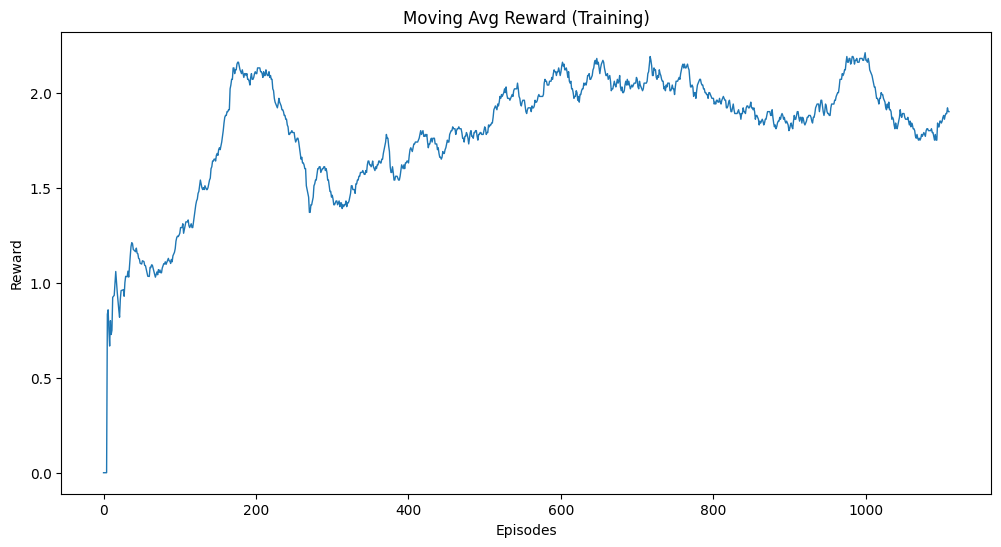

In [109]:
# YOUR CODE HERE

# Show the moving average reward of the training process

import matplotlib.pyplot as plt

steps, train_reward, eval_score, _ = result.T

plt.figure(figsize=(12,6))

plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

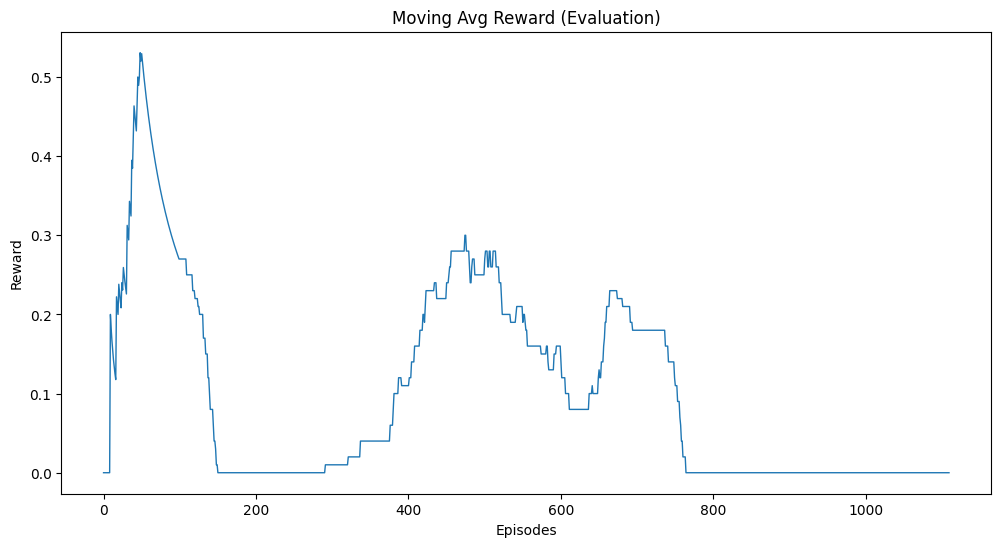

In [110]:
# YOUR CODE HERE

# Show the moving average reward of the evaluation process

plt.figure(figsize=(12,6))

plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

9 - show the policy behaviour

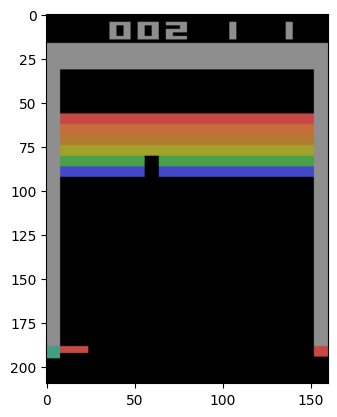

In [111]:
# YOUR CODE HERE

# You can show the policy learned by the agent using the show_policy function


















